In [6]:
import os
import cv2
import numpy as np
from math import floor
from os.path import join
from os.path import isfile
from google.colab.patches import cv2_imshow
import time

In [7]:
# For basic alignment calculation
def calculate_ncc(im1, im2):
    data1 = (im1-np.mean(im1)) / np.std(im1, ddof = 1)
    data2 = (im2-np.mean(im2)) / np.std(im2, ddof = 1)
    res = -1 * np.sum(data1*data2)
    return res

#def roll_image(im)
def alignNCC(im1, im2):
    minimum = float("inf")
    bestdx = 0
    bestdy = 0
    result = im1

    for dx in range(-15, 16):
        for dy in range(-15, 16):
            #shift the image
            shift_img = np.roll(im1, dx, axis = 0)
            shift_img = np.roll(shift_img, dy, axis = 1)

            #calculate and update the best result
            ncc = calculate_ncc(shift_img, im2)
            if ncc < minimum:
                minimum = ncc
                bestdx, bestdy = dx, dy
                result = shift_img
    
    return bestdx, bestdy, result

In [8]:
# references: 
# ORB image matching https://www.askpython.com/python-modules/feature-matching-in-images-opencv; 
# https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
# https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/

def alignORB(im1, im2):
    orb = cv2.ORB_create(nfeatures = 5000)
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)

    #create bruteforce mathcer using hamming distance & cross check
    bfmatcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bfmatcher.match(des1, des2)
    
    #get top 20% matched results 
    matches = sorted(matches, key = lambda x:x.distance)
    match_img = cv2.drawMatches(im1, kp1, im2, kp2, matches[:int(len(matches)*0.3)], None)
    #cv2_imshow(match_img)
    #cv2.waitKey()
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
   
    for (i, m) in enumerate(matches):
      ptsA[i] = kp1[m.queryIdx].pt
      ptsB[i] = kp2[m.trainIdx].pt
	  #compute the homography matrix
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    (h, w) = im2.shape

    #align the image
    aligned = cv2.warpPerspective(im1, H, (w, h))
    return aligned

In [14]:
################################################
# For SSD alignment score. Not used
################################################
"""
def SSD(im1, im2):
    return np.sum((im1 - im2)**2)
"""

In [25]:
# crop some border for better alignment 
def crop_image(im, ratio=0.1):
    height, width = im.shape
    im = im[int(height*(ratio)):int(height*(1-ratio)), int(width*(ratio)):int(width*(1-ratio))]
    return im

# Roll the image
def transform(im, dx, dy):
    im = np.roll(im, dx, axis = 0)
    im = np.roll(im, dy, axis = 1)
    return im

# function to align image with different method
def align_image(im, method="NCC"):
    height = int(im.shape[0]/3)
    width = int(im.shape[1])
    
    li = []
    #Best result is to align two other channle to the red channel
    for i in range(3):
        img = im[i*height:(i+1)*height]
        img = crop_image(img, ratio = 0.06) #0.05 work best for the man image
        li.append(img)
   
    # original alignment withoug any shift
    color_image = np.dstack(li)
    #cv2_imshow(color_image)

    #========================================
    #ORB and wrap method
    if(method == "ORB"):
        for i in range(0, 2):
            color_image[:,:,i] = alignORB(color_image[:,:,i], color_image[:,:,2])
    #========================================
    #NCC shift method
    if(method == "NCC"):
        bx, by, shifted_b = alignNCC(li[0], li[2])
        gx, gy, shifted_g = alignNCC(li[1], li[2])
    
        color_image = np.dstack([shifted_b, shifted_g, li[2]])

        print("aligned result: ", "Blue shifted x =", bx, "y =", by)
        print("Green shifted x =", gx, "y =", gy)
    #========================================
    if(method == "Pyramid"):
        bx, by = align_pyramid(li[0], li[2])
        shifted_b = transform(li[0], bx, by)
        gx, gy = align_pyramid(li[1], li[2])
        shifted_g = transform(li[1], gx, gy)
        print("color image generated, showing......")
        color_image = np.dstack([shifted_b, shifted_g, li[2]])
        print("aligned result: ", "Blue shifted x =", bx, "y =", by)
        print("Green shifted x =", gx, "y =", gy)
    #========================================
    cv2_imshow(color_image)
    return color_image

In [22]:
# References
# https://medium.com/analytics-vidhya/a-beginners-guide-to-computer-vision-part-4-pyramid-3640edeffb00
# https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/
# function for pyramid building and alignment
import imutils
def pyramid_img(im, scale=0.5):
    height = int(im.shape[0]/3)
    width = int(im.shape[1])

    levels = min(int(np.log(height)), int(np.log(width))) // 2

    pyramids = []
    pyramids.append(im)
   
    for i in range(1, levels):
        sml_img = imutils.resize(pyramids[i-1], width=int(pyramids[i-1].shape[1] * scale))
        pyramids.append(sml_img)

    return pyramids

def align_pyramid(img1, img2):
    pyramids1 = pyramid_img(img1)
    pyramids2 = pyramid_img(img2)
    bestdx = 0
    bestdy = 0

    print("aligning......")
    for im1,im2 in zip(reversed(pyramids1),reversed(pyramids2)):
        #remove images that are too large
        if(max(im1.shape)) > 5000:
            break
        #each lavel enlarge according to the scale
        bestdx *= 2
        bestdy *= 2
        im1 = transform(im1, bestdx, bestdy)
        #used ssd to reduce running time but result was bad
        dx, dy, res_img = alignNCC(im1, im2)
        bestdx, bestdy = bestdx+dx, bestdy+dy

    return bestdx, bestdy


aligned result:  Blue shifted x = -14 y = -5
Green shifted x = -7 y = -2


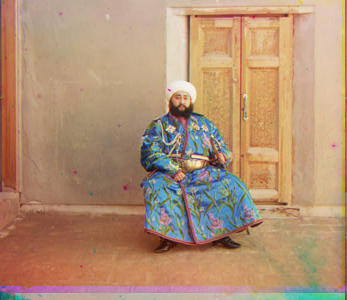

In [ ]:
# Basic alignment
myPath = "/content/drive/MyDrive/single/"
start_time = time.time()
for filename in os.listdir(myPath):
    f = join(myPath, filename)
    im = cv2.imread(f, 0) # read image
    align_image(im, "NCC")
print("--- total is %s seconds ---" % (time.time() - start_time))

In [ ]:
# Multiple alignment
myPath = "/content/drive/MyDrive/hires/"
for filename in os.listdir(myPath):
    f = join(myPath, filename)
    im = cv2.imread(f, 0) # read image
    start_time = time.time()
    align_image(im, "Pyramid")
    print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
# reference :http://cs.brown.edu/courses/cs129/results/proj1/chenx/

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/


[Errno 2] No such file or directory: '/content/drive/MyDrive/Github/'
/content
